# Выплатят ли по страховке или нет? Как узнать?

#### Ссылка на датасет:
https://www.ibm.com/communities/analytics/watson-analytics-blog/insurance-weather-use-case-datasets/

#### Описание данных
Данные были выбраны по искам страховщиков  страховой(-ым) комании(-ям) в отношении автострахования в США. В датасете представлена следующая информация по каждому иску: данные о клиенте (id, образование, пол, занятость и др.), о страховке (канал продаж, ежемесячная плата, срок действия, кол-во месяцев с прошлого требования и др.), об автомобиле, и непосредственно о требовании (размер, причина, результат и др.). Всего в датасете 25 столбцов-характеристик и 9135 строк-объектов.

#### Основная задача
Определить влияющие факторы и построить прогнозирующую модель результата иска (удовлетворен/не удовлетворен) для выявления клиентов, которым чаще всего удовлетворяют иски, чтобы повышать понимать, какие расходы может понести страховая компания

In [470]:
import numpy as np
import pandas as pd
import os as os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pydotplus
import xgboost as xgb

from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.externals.six import StringIO 
from sklearn.linear_model import LogisticRegression
from IPython.display import Image 
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams["patch.force_edgecolor"] = True
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Импортируем данные об исках по автострахованию из датасета

In [360]:
df = pd.read_csv('Claims-and-Weather-Sample.csv')

## 1. Разведывательный анализ

### 1.1 Знакомство с данными

In [361]:
df.head()

Customer State Code     State  Claim Amount Response  Coverage Education  \
0  BU79786         KS    Kansas    276.351928       No     Basic  Bachelor   
1  QZ44356         NE  Nebraska    697.953590       No  Extended  Bachelor   
2  AI49188         OK  Oklahoma   1288.743165       No   Premium  Bachelor   
3  WW63253         MO  Missouri    764.586183       No     Basic  Bachelor   
4  HB64268         KS    Kansas    281.369258       No     Basic  Bachelor   

  Effective To Date EmploymentStatus Gender     ...       \
0         2/24/2011         Employed      F     ...        
1         1/31/2011       Unemployed      F     ...        
2         2/19/2011         Employed      F     ...        
3         1/20/2011       Unemployed      M     ...        
4          2/3/2011         Employed      M     ...        

   Months Since Policy Inception Number of Open Complaints Number of Policies  \
0                              5                         0                  1   
1                             42                         0                  8   
2                             38                         0                  2   
3                             65                         0                  7   
4                             44                         0                  1   

      Policy Type        Policy  Claim Reason  Sales Channel  \
0  Corporate Auto  Corporate L3     Collision          Agent   
1   Personal Auto   Personal L3  Scratch/Dent          Agent   
2   Personal Auto   Personal L3     Collision          Agent   
3  Corporate Auto  Corporate L2     Collision    Call Center   
4   Personal Auto   Personal L1     Collision          Agent   

   Total Claim Amount  Vehicle Class Vehicle Size  
0          384.811147   Two-Door Car      Medsize  
1         1131.464935  Four-Door Car      Medsize  
2          566.472247   Two-Door Car      Medsize  
3          529.881344            SUV      Medsize  
4          138.130879  Four-Door Car      Medsize  

[5 rows x 25 columns]

#### Данные State и State Code дублируют информацию. Уберем столбец State Code

In [362]:
df = df.drop('State Code', axis=1)

In [363]:
df.head()

Customer     State  Claim Amount Response  Coverage Education  \
0  BU79786    Kansas    276.351928       No     Basic  Bachelor   
1  QZ44356  Nebraska    697.953590       No  Extended  Bachelor   
2  AI49188  Oklahoma   1288.743165       No   Premium  Bachelor   
3  WW63253  Missouri    764.586183       No     Basic  Bachelor   
4  HB64268    Kansas    281.369258       No     Basic  Bachelor   

  Effective To Date EmploymentStatus Gender  Income     ...       \
0         2/24/2011         Employed      F   56274     ...        
1         1/31/2011       Unemployed      F       0     ...        
2         2/19/2011         Employed      F   48767     ...        
3         1/20/2011       Unemployed      M       0     ...        
4          2/3/2011         Employed      M   43836     ...        

  Months Since Policy Inception Number of Open Complaints  Number of Policies  \
0                             5                         0                   1   
1                            42                         0                   8   
2                            38                         0                   2   
3                            65                         0                   7   
4                            44                         0                   1   

      Policy Type        Policy  Claim Reason  Sales Channel  \
0  Corporate Auto  Corporate L3     Collision          Agent   
1   Personal Auto   Personal L3  Scratch/Dent          Agent   
2   Personal Auto   Personal L3     Collision          Agent   
3  Corporate Auto  Corporate L2     Collision    Call Center   
4   Personal Auto   Personal L1     Collision          Agent   

  Total Claim Amount  Vehicle Class Vehicle Size  
0         384.811147   Two-Door Car      Medsize  
1        1131.464935  Four-Door Car      Medsize  
2         566.472247   Two-Door Car      Medsize  
3         529.881344            SUV      Medsize  
4         138.130879  Four-Door Car      Medsize  

[5 rows x 24 columns]

In [364]:
df.tail()

Customer     State  Claim Amount Response  Coverage Education  \
9129  LA72316  Missouri   2340.598798       No     Basic  Bachelor   
9130  PK87824  Missouri    309.651122      Yes  Extended   College   
9131  TD14365  Missouri    816.389043       No  Extended  Bachelor   
9132  UP19263  Missouri    752.444244       No  Extended   College   
9133  Y167826  Missouri    261.183687       No  Extended   College   

     Effective To Date EmploymentStatus Gender  Income     ...       \
9129         2/10/2011         Employed      M   71941     ...        
9130         2/12/2011         Employed      F   21604     ...        
9131          2/6/2011       Unemployed      M       0     ...        
9132          2/3/2011         Employed      M   21941     ...        
9133         2/14/2011       Unemployed      M       0     ...        

     Months Since Policy Inception Number of Open Complaints  \
9129                            89                         0   
9130                            28                         0   
9131                            37                         3   
9132                             3                         0   
9133                            90                         0   

      Number of Policies     Policy Type        Policy  Claim Reason  \
9129                   2   Personal Auto   Personal L1          Hail   
9130                   1  Corporate Auto  Corporate L3     Collision   
9131                   2  Corporate Auto  Corporate L2     Collision   
9132                   3   Personal Auto   Personal L2  Scratch/Dent   
9133                   1  Corporate Auto  Corporate L3         Other   

      Sales Channel Total Claim Amount  Vehicle Class Vehicle Size  
9129            Web         198.234764  Four-Door Car      Medsize  
9130         Branch         379.200000  Four-Door Car      Medsize  
9131         Branch         790.784983  Four-Door Car      Medsize  
9132         Branch         691.200000  Four-Door Car        Large  
9133    Call Center         369.600000   Two-Door Car      Medsize  

[5 rows x 24 columns]

#### Хоть и по последнему индексу и количеству столбцов можно и так определить, все же выведем размерность датасета

In [365]:
df.shape

(9134, 24)

#### Проверим тип данных каждой переменной, все ли значения указаны, нет ли пропусков

In [366]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
Customer                         9134 non-null object
State                            9134 non-null object
Claim Amount                     9134 non-null float64
Response                         9134 non-null object
Coverage                         9134 non-null object
Education                        9134 non-null object
Effective To Date                9134 non-null object
EmploymentStatus                 9134 non-null object
Gender                           9134 non-null object
Income                           9134 non-null int64
Location Code                    9134 non-null object
Marital Status                   9134 non-null object
Monthly Premium Auto             9134 non-null int64
Months Since Last Claim          9134 non-null int64
Months Since Policy Inception    9134 non-null int64
Number of Open Complaints        9134 non-null int64
Number of Policies               

#### Интерпретируем каждую переменную, чтобы быть в курсе дела

* Customer - номер клиента
* State - штат
* Claim Amount - сумма иска
* Response - ответ страховой компании
  * Yes
  * No
* Coverage - вид покрытия ущерба
  * Basic
  * Extended
  * Premium
* Education - образование
  * High School or Below
  * College
  * Bachelor
  * Master
* Effective To Date - срок действия страховки
* Gender - пол
* Income - годовой доход в долл. США
* Location Code - код месторасположения
  * Rural
  * Suburban
  * Urban
* Marital Status - семейное положение
* Monthly Premium Auto - ежемесячный платеж по автостраховке
* Months Since Last Claim - месяцев с последнего иска
* Months Since Policy Inception - месяцев с начала действия полиса автострахования
* Number of Open Complaints - количество открытых жалоб
* Number of Policies - количество полисов
* Policy Type - тип полиса
  * Corporate Auto
  * Personal Auto
  * Special Auto
* Policy - полис (L1, L2, L3 на каждый тип полиса)
* Claim Reason - причина иска
  * Collision - ДТП
  * Hail - град
  * Scratch/Dent - царапина/вмятина
  * Other
* Sales Channel - канал продаж
* Total Claim Amount - итоговая сумма иска
* Vehicle Class - класс ТС (6 типов)
* Vehicle Size - размер ТС (3 типа)

### 1.2 Построим и рассмотрим графики распределений количественных переменных

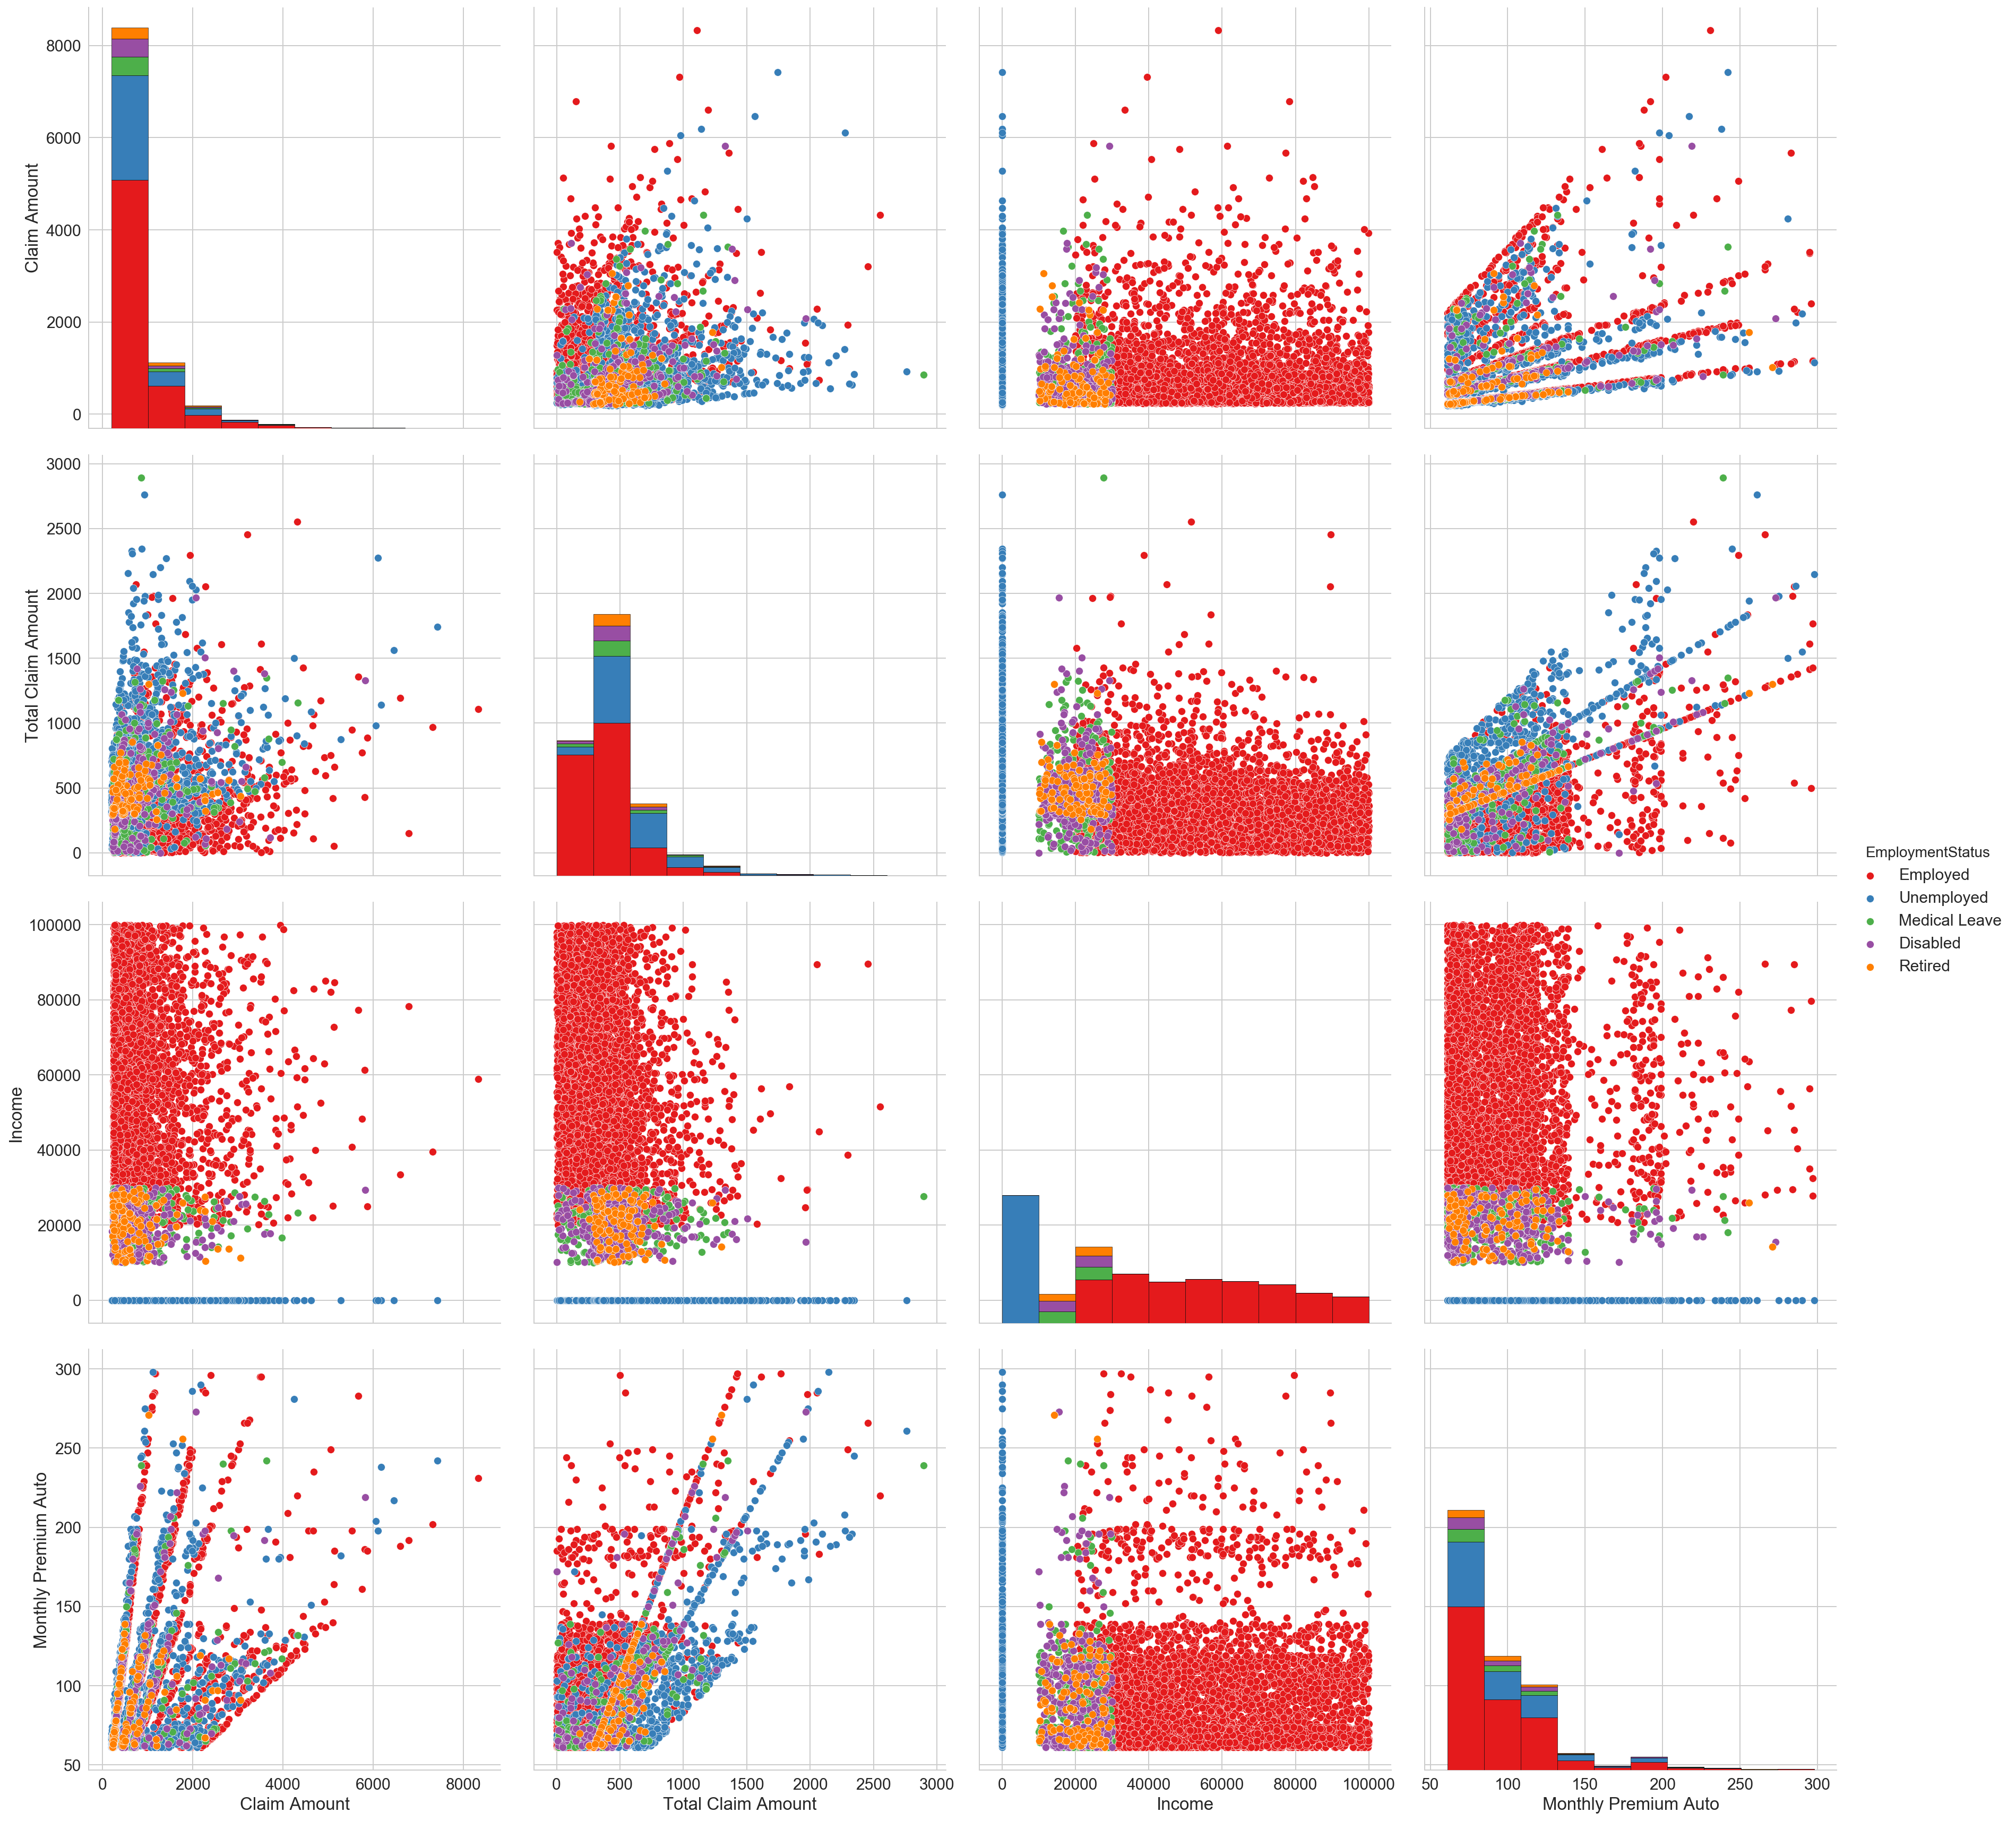

In [452]:
cols = ['Claim Amount', 'Total Claim Amount', 'Income', 'Monthly Premium Auto', 'EmploymentStatus', 'Gender',
                                                                                        'Response','Marital Status']
sns.pairplot(df[cols], hue='EmploymentStatus', palette='Set1', size=6)

* По графику распределения "суммы иска" можно сделать вывод, что доля исков на сумму < 1000 долл США очень велика
* По графику распределения "итоговой суммы иска" можно заметить, что итоговая сумма иска у большинства истцов не превышает 600 долл США
* По графику распределения "доходов" истцов видно, что больше всего истцов с нулевым доходом

* Возможно наличие связи между "Суммой иска" и "Ежемесячный платеж по автостраховке"; "Итоговой суммой иска" и "Ежемесячнаый платеж по автостраховке", и логично было бы предположить связь между "Суммой иска" и "Итоговой суммой иска"
* По цветовой гамме можно определить, что у занятые иско-заявителе при большем доходе платят те же ежемесячные суммы, что и остальные

In [368]:
print("График распределения Claim Amount:", round(df[df['Claim Amount'] < 1000].shape[0]/df.shape[0]*100, 2), '% исков с суммой требования < 1000$')
print("График распределения Total Claim Amount:", round(df[df['Total Claim Amount'] < 600].shape[0]/df.shape[0]*100, 2), '% исков, где итоговая исковая сумма составляет < 600$')
print("График распределения Income:", round(df[df['Income'] == 0].shape[0]/df.shape[0]*100, 2), '% исков от клиентов с доходом равным 0$')

График распределения Claim Amount: 79.35 % исков с суммой требования < 1000$
График распределения Total Claim Amount: 80.04 % исков, где итоговая исковая сумма составляет < 600$
График распределения Income: 25.37 % исков от клиентов с доходом равным 0$


#### Осталось еще пара менее важных количественных переменных, посмотрим, что можно на их графике увидеть

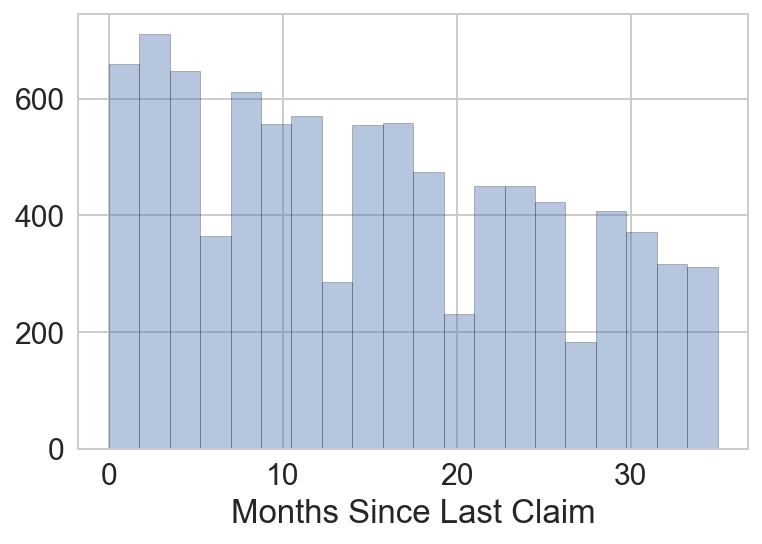

In [369]:
sns.distplot(df['Months Since Last Claim'], kde=False, bins=20)

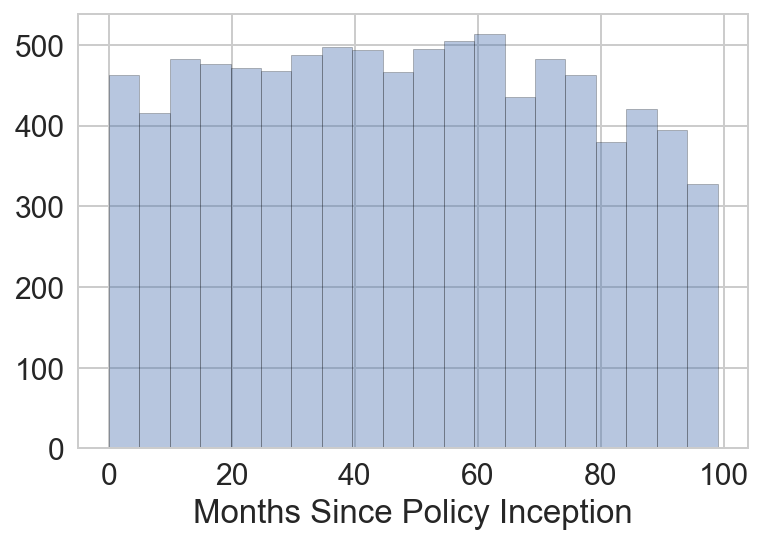

In [370]:
sns.distplot(df['Months Since Policy Inception'], kde=False, bins=20)

* По графику Months Since Last Claim четко видно, что с увеличением переменной количество иско-заявителей становится меньше
* По графику Months Since Policy Inception можно наблюдать, что данная переменная практически не влияет (или влияет очень слабо) на количсетсво иско-заявителей

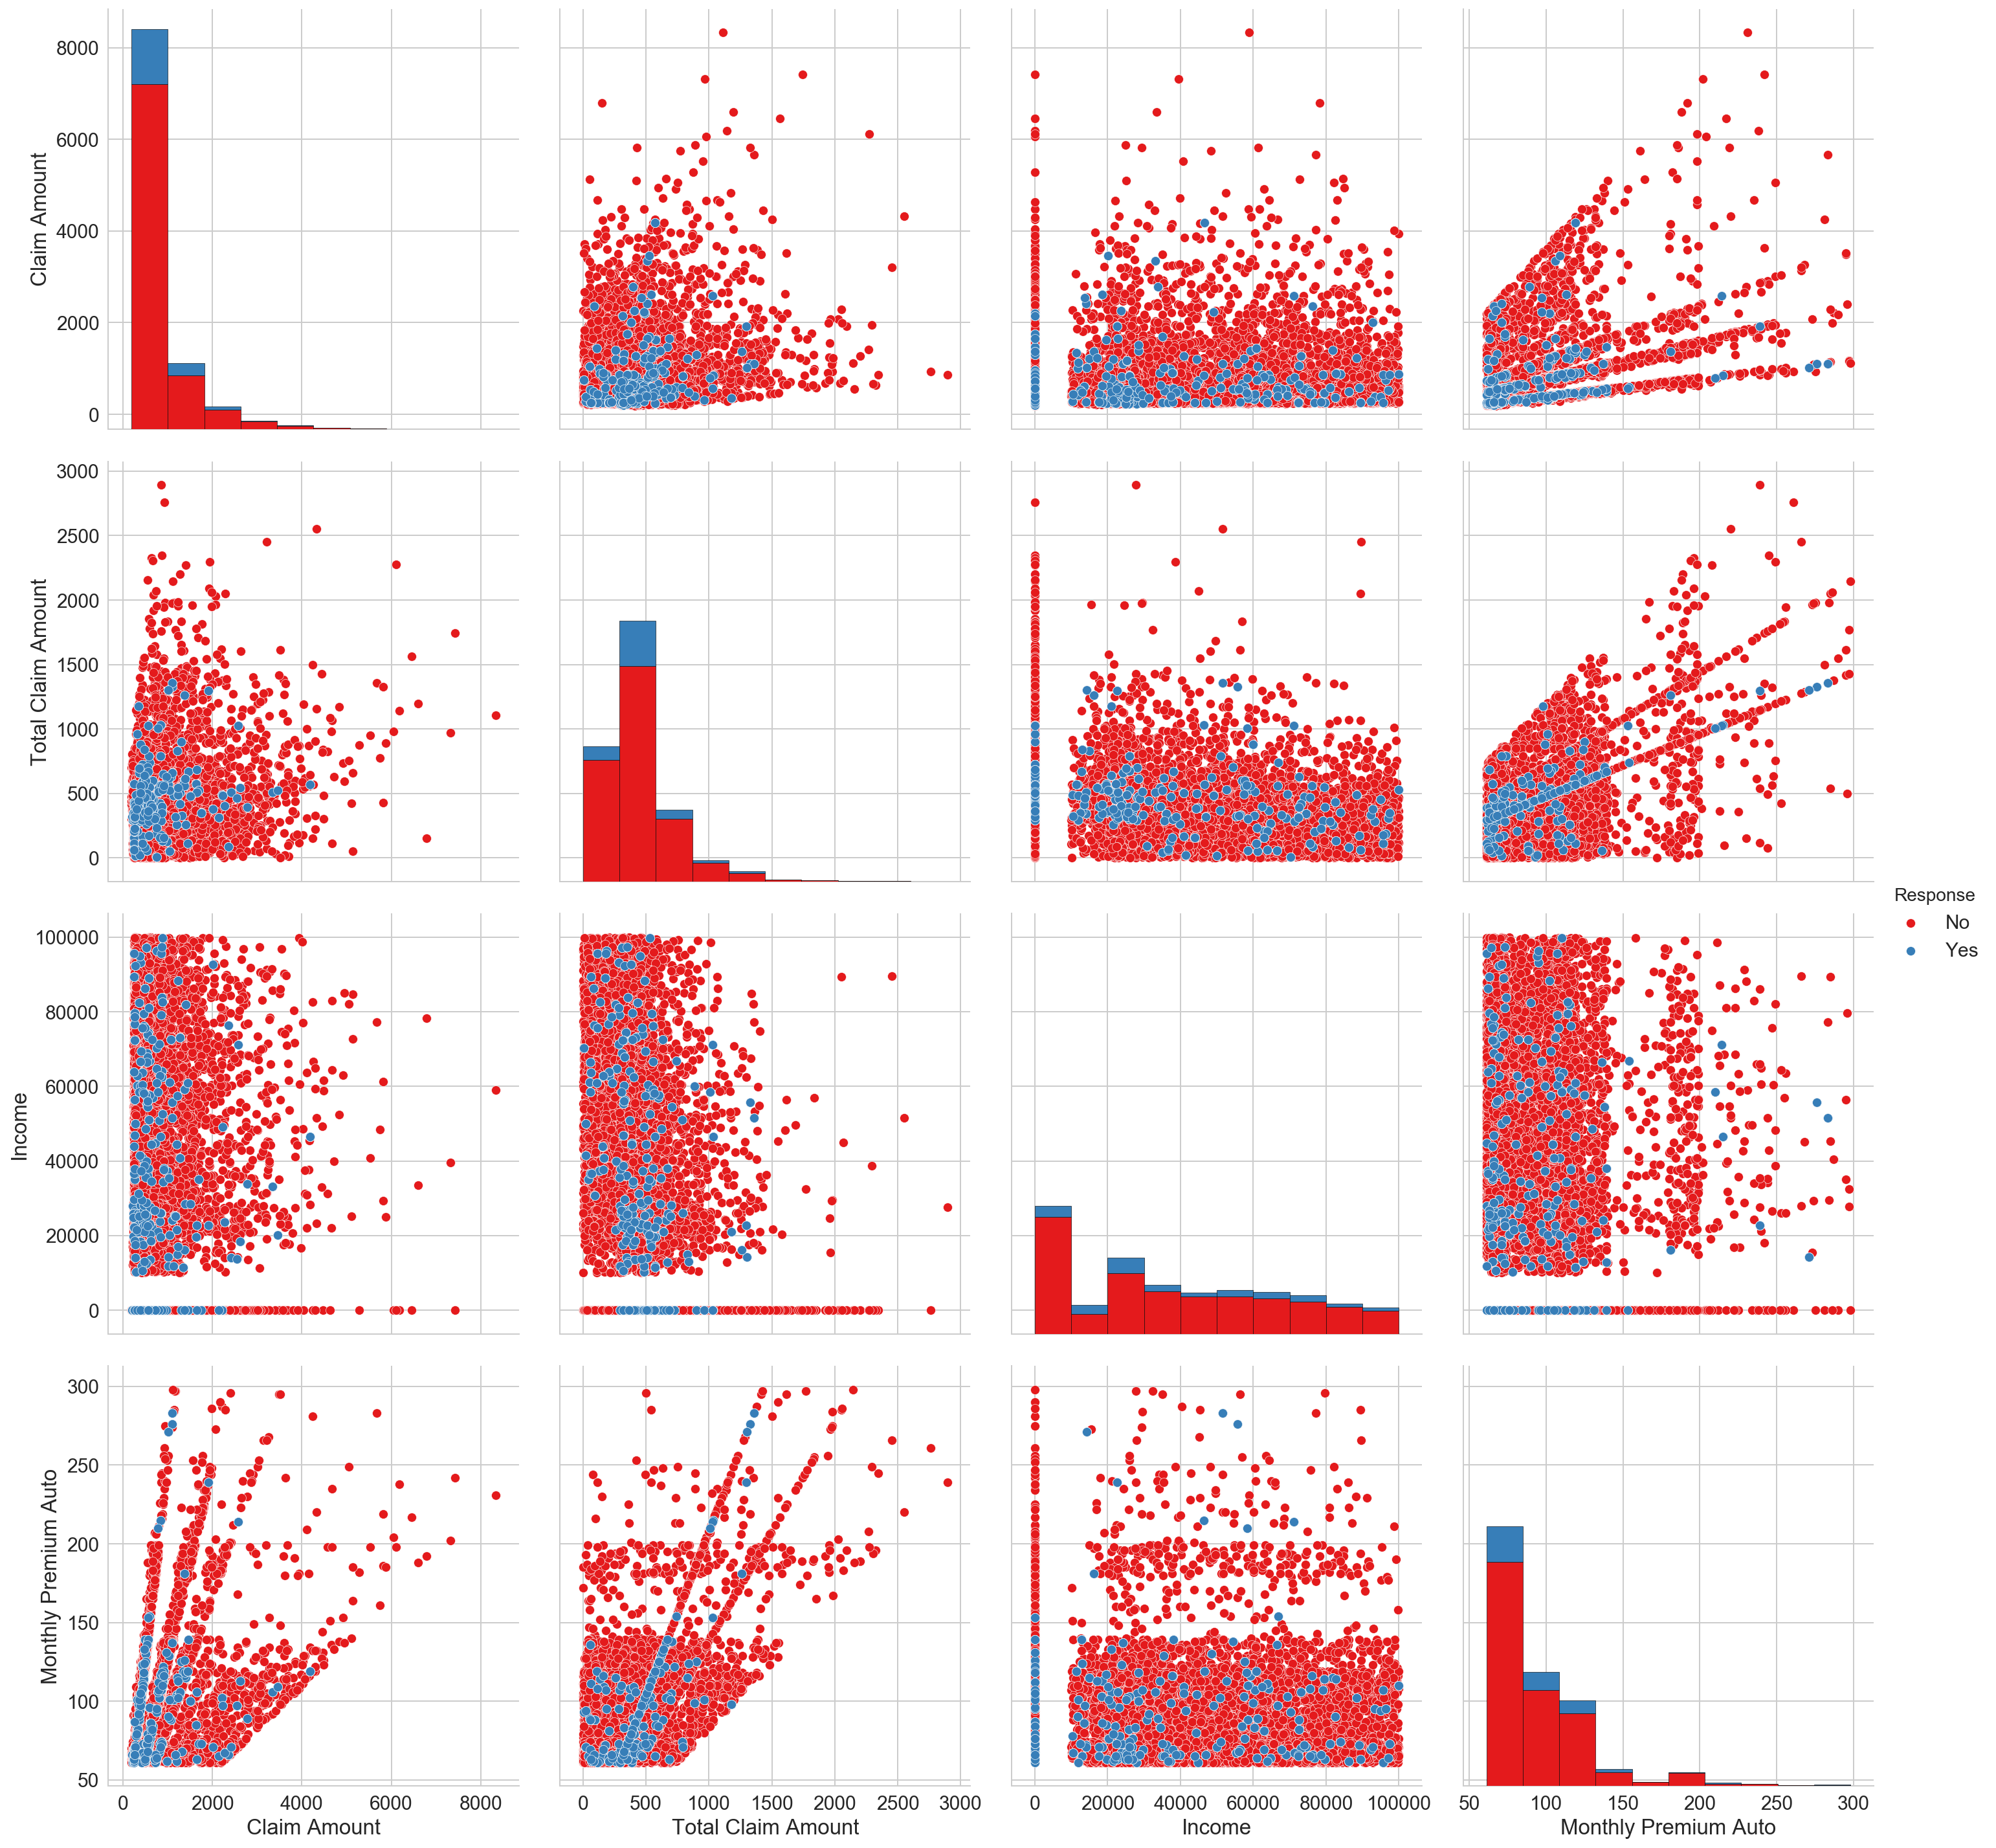

In [453]:
cols2 = ['Claim Amount', 'Total Claim Amount', 'Income', 'Monthly Premium Auto', 'EmploymentStatus', 'Gender',
                                                                                        'Response','Marital Status']
sns.pairplot(df[cols], hue='Response', palette='Set1', size=5)

### 1.4 Визуализируем матрицу корреляций

#### Перед этим выдвенем гипотезы по графикам выше и согласно логическим рассуждениям:
* Между Claim Amount и Months Premium Auto прослеживается положительная связь (средняя)
* Между Total Claim Amount и Months Premium Auto прослеживается положительная связь (средняя)
* Между Claim Amount и Total Claim Amount прослеживается положительная связь (слабая)

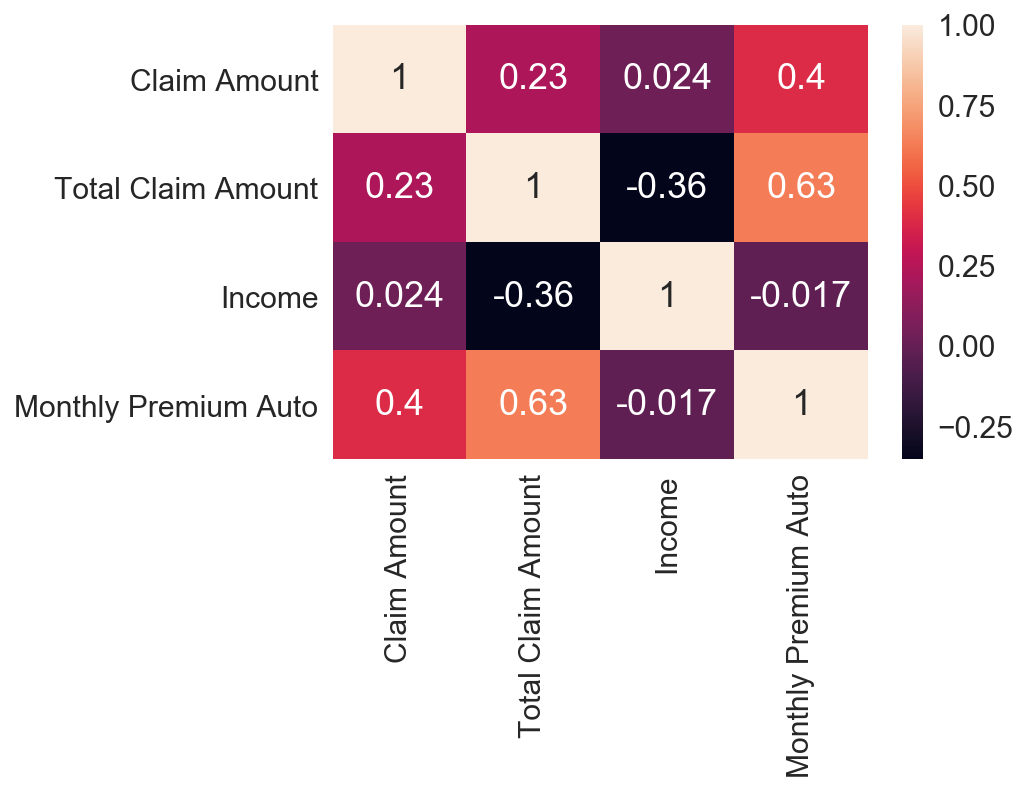

In [371]:
sns.set(font_scale=1.5)
matr_corr = sns.heatmap(df[cols].corr(),
                 cbar=True,
                 annot=True)

## 2. Модели

#### Переведем качественные переменные из текстого в цифровой вид

In [372]:
Y_feature = df['Response'].apply(lambda x: 0 if x == 'No' else 1)
Y_feature

0       0
1       0
2       0
3       0
4       0
5       1
6       1
7       0
8       1
9       0
10      0
11      0
12      0
13      1
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      1
23      0
24      0
25      0
26      0
27      0
28      0
29      0
       ..
9104    0
9105    0
9106    0
9107    1
9108    0
9109    0
9110    1
9111    0
9112    0
9113    0
9114    0
9115    0
9116    0
9117    0
9118    0
9119    1
9120    0
9121    0
9122    1
9123    1
9124    0
9125    0
9126    0
9127    0
9128    0
9129    0
9130    1
9131    0
9132    0
9133    0
Name: Response, Length: 9134, dtype: int64

In [373]:
X = df.drop(['Customer', 'Response'], 1)
X_numeric = X.select_dtypes(include='number')
X_object = X.select_dtypes(exclude='number')

In [374]:
X_object['Effective To Date'] = pd.to_datetime(pd.to_datetime(X_object['Effective To Date'], 
                                                             infer_datetime_format = True))
X_object['today'] = pd.to_datetime('2011-09-03')
X_numeric['Days until expire'] = (X_object['today'] - X_object['Effective To Date']).dt.days
X_object = X_object.drop(['today', 'Effective To Date'],1)

In [375]:
X_object = pd.get_dummies(X_object)
X_object.shape

(9134, 55)

In [376]:
X_features = pd.concat([X_numeric, X_object], axis=1)
X_features.shape

(9134, 64)

#### Разделим выборку на обучающую и тестовую

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_feature, test_size=0.3, random_state=5)

### 2.1 Логистическая регрессия (без регуляризации)

In [378]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_train, y_train), logreg.score(X_test, y_test)

(0.8604723916783983, 0.8482305727836555)

In [407]:
cv_logreg = cross_val_score(LogisticRegression(), X_train, y_train, cv=3)
print(cv_logreg,'\n', cv_logreg.mean())

[0.86022514 0.86062881 0.86056338] 
 0.8604724445861988


### 2.2 Логистическая регрессия (с регуляризацией)

In [413]:
logreg2 = LogisticRegression(C=5)
logreg2.fit(X_train, y_train)
logreg2.score(X_train, y_train), logreg2.score(X_test, y_test)

(0.8604723916783983, 0.8482305727836555)

In [414]:
cv_logreg2 = cross_val_score(logreg2, X_train, y_train, cv=3)
print(cv_logreg2,'\n', cv_logreg2.mean())

[0.86022514 0.86062881 0.86056338] 
 0.8604724445861988


Такое же значение, как и у кросс-валидации логрегрессии без регуляризации

### 2.3 Дерево решений

In [418]:
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,7],
    'min_samples_split': [3,5,7]
}

In [465]:
dt = DecisionTreeClassifier()
cv_dt = GridSearchCV(dt, tree_params, cv=5, scoring='f1')
cv_dt.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 5, 7], 'min_samples_split': [3, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [424]:
cv_dt.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [425]:
cv_dt.best_score_

0.46032499883169803

In [388]:
preds = cv.predict(X_test)

print(classification_report(y_test, preds))

             precision    recall  f1-score   support

          0       0.89      0.98      0.93      2325
          1       0.70      0.32      0.44       416

avg / total       0.86      0.88      0.86      2741



In [389]:
print(confusion_matrix(y_test, preds))

[[2268   57]
 [ 281  135]]


In [390]:
pd.Series(y_test).value_counts()

0    2325
1     416
Name: Response, dtype: int64

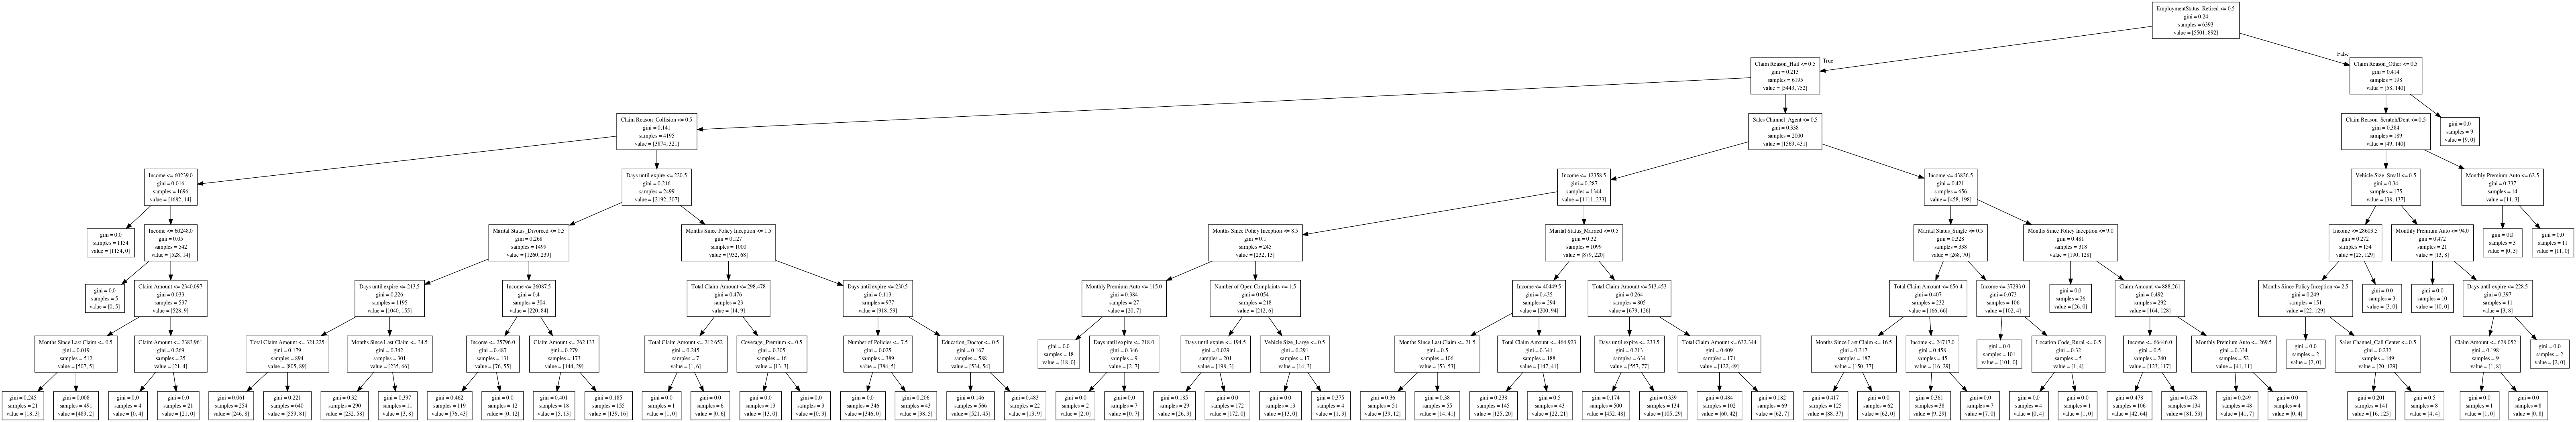

In [391]:
dot_data = tree.export_graphviz(cv.best_estimator_, out_file=None, 
feature_names=X_features.columns) 

graph = pydotplus.graph_from_dot_data(dot_data) 

Image(graph.create_png())

In [ ]:
graph.write_png('tree.png')

### 2.4 Голосование

In [466]:
voting = VotingClassifier(estimators=[('lr', logreg), ('dt', dt), ('lr2', logreg2)], voting='hard')
voting.fit(X_train,y_train)
voting.score(X_train,y_train), voting.score(X_test,y_test)

(0.8612544971062099, 0.8464064210142284)

In [467]:
cv_voting = cross_val_score(voting, X_train, y_train, cv=3)
print(cv_voting,'\n', cv_voting.mean())

[0.86116323 0.86109808 0.86150235] 
 0.8612545501517911


Значение чуть больше, чем у логрегрессии

### 2.5 Бэггинг

In [474]:
bagging = BaggingClassifier(base_estimator=dt, n_estimators=100, random_state=18)
bagging.fit(X_train,y_train)
bagging.score(X_train,y_train), bagging.score(X_test,y_test)

(1.0, 0.9919737322145202)

In [475]:
cv_bag = cross_val_score(bagging, X_train, y_train, cv=3, scoring = "f1_macro")
print(cv_bag,'\n', cv_bag.mean())

[0.96197339 0.96280846 0.93307905] 
 0.9526203002135015


Значение стало очень большим после того, как я заменил базу оценки с логрегрессии на дерево решений

### 2.4 Случайный лес

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_feature, test_size=0.3, random_state=18)

rf_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3,5,7],
    'min_samples_split': [3,5,7],
    'n_estimators': [100,300,500]
}

cv_rf = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, scoring='f1', n_jobs=-1)
cv_rf.fit(X_train, y_train)

In [456]:
preds_rf = cv_rf.predict(X_test)
print(classification_report(y_test, preds_rf))

             precision    recall  f1-score   support

          0       0.90      0.98      0.94      2320
          1       0.78      0.38      0.51       421

avg / total       0.88      0.89      0.87      2741



In [461]:
print(confusion_matrix(y_test, preds_rf))

[[2275   45]
 [ 261  160]]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_feature, test_size=0.3, random_state=18)

xgb_params = {
    'max_depth': [3,5,7],
    'n_estimators': [100,300,500],
    'learning_rate': [0.01, 0.05, 0.1]
}

cv_xgb = GridSearchCV(xgb.XGBClassifier(), xgb_params, cv=5, scoring='f1', n_jobs=-1)
cv_xgb.fit(X_train, y_train)

In [459]:
preds_xgb = cv_xgb.predict(X_test)
print(classification_report(y_test, preds_xgb))

             precision    recall  f1-score   support

          0       1.00      0.99      1.00      2320
          1       0.97      1.00      0.99       421

avg / total       1.00      1.00      1.00      2741



In [462]:
print(confusion_matrix(y_test, preds_xgb))

[[2308   12]
 [   0  421]]


#### Как видим, последняя модель (xgboost) оказалась самая результативная (возможно и переобученная) для прогнозирования ответа страховой компании по исковому заявлению